In [14]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal

import os
import pandas as pd

from skimage import morphology, graph
import skfmm

In [2]:
def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def clean_zeros_2d(img, pad=2):
    foo = np.nonzero(np.any(img, axis=0))[0]
    vceros = np.array([ max([0,foo[0] - pad]), min([img.shape[1], foo[-1]+pad]) ])
    
    foo = np.nonzero(np.any(img, axis=1))[0]
    hceros = np.array([ max([0,foo[0] - pad]), min([img.shape[0], foo[-1]+pad]) ])

    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
    
    return img, vceros, hceros

In [71]:
genotypes = ['CAL','MLB','222','299','517','521']
imtype = ['Diseased', 'Healthy', 'Binary']
runnum = 2
src = '../run{:02d}/'.format(runnum)

gidx = 0
dfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[0], genotypes[gidx])))
hfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[1], genotypes[gidx])))
bfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[2], genotypes[gidx])))

print('Total number of files:\t{}'.format(len(dfiles)))
bfiles

Total number of files:	6


['../run02/Binary_Images/1-CAL-1-M212_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/1-CAL-2-F243_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/2-CAL-2-M249_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/4-CAL-2-F-1-417_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/5-CAL-1-M-1-031_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/5-CAL-2-F-1- 040_ivc.jpg_Binary_roots.jpg']

In [72]:
idx = 0
print(bfiles[idx])
bimg = read_binary_img(bfiles[idx])
if False:
    dimg = bimg*read_binary_img(dfiles[idx])
    himg = bimg*read_binary_img(hfiles[idx])
    simg = dimg + himg
    print('Pixels in binary but NOT in sum:\t{}'.format(np.sum(~simg*bimg)))
    print('Pixels in sum but NOT in binary:\t{}'.format(np.sum(~bimg*simg)))

../run02/Binary_Images/1-CAL-1-M212_ivc.jpg_Binary_roots.jpg


In [73]:
img = bimg.copy()
img, vceros, hceros = clean_zeros_2d(img)
img = ndimage.binary_dilation(img, ndimage.generate_binary_structure(2,1), 3)
print(vceros, hceros, sep='\n')

[1614 5277]
[   0 5608]


In [74]:
label, nums = ndimage.label(img, structure=ndimage.generate_binary_structure(2,2))
print('Found',nums,'connected components')
hist, bins = np.histogram(label, bins=range(1,nums+2))
print(np.round(100*np.sort(hist)[::-1]/np.sum(hist),1))
print(np.sort(hist)[::-1])
hargsort = np.argsort(hist)[::-1]
thr = np.sum(100*hist/np.sum(hist) > 0.05)

main = img.copy()
main[label != bins[hargsort[0]]] = False
edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)

Found 119 connected components
[91.6  0.4  0.4  0.3  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0. ]
[1987485    8054    7814    5671    5421    5282    4828    4786    4765
    4568    4369    4187    4160    4126    3707    3566    3478    3444
    3165    2996    2922    2874    2827    2709    2453    1794    1680
    1599    1532    1492    1462    1435    1390    1363    1358    1301
    1286    1243    1238    1229    1208    1196    1169    1147    1128
    

In [75]:
pad = 5
gimg = img.copy()

for jj in range(1,len(hargsort)):

    box = img.copy()
    box[label != bins[hargsort[jj]]] = False
    sbox = morphology.skeletonize(box)
    g,nodes = graph.pixel_graph(sbox, connectivity=2)
    argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
    leafx = nodes[argleaf]%sbox.shape[1]
    leafy = nodes[argleaf]//sbox.shape[1]
    eidx = np.zeros((len(leafx), 2), dtype=int)
    for i in range(len(eidx)):
        eidx[i] = edt[:, leafy[i], leafx[i]]

    sdist = np.zeros(len(leafx))
    for i in range(len(sdist)):
        sdist[i] = (leafx[i]-eidx[i,1])**2 + (leafy[i]-eidx[i,0])**2
    sdist = np.sqrt(sdist)
    cidx = np.argmin(sdist)

    if sdist[cidx] < 300:
        p0 = np.array([leafx[cidx], leafy[cidx]])
        p1 = eidx[cidx][::-1]
        
        lams = np.linspace(0,1, 2*int(sdist[cidx]))
        
        for i in range(len(lams)):
            line = p0 + lams[i]*(p1 - p0)
            line = line.astype(int)
            gimg[ line[1]-pad:line[1]+pad, line[0]-pad:line[0]+pad] = True

    else:
        gimg[ label == bins[hargsort[jj]]] = False

foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,2))
print('Found',bar,'connected components')

Found 1 connected components


In [76]:
if False:
    sdist = np.zeros(len(leafx))
    for i in range(len(dist)):
        sdist[i] = (leafx[i]-eidx[i,1])**2 + (leafy[i]-eidx[i,0])**2
    sdist = np.sqrt(sdist)
    cidx = np.argmin(sdist)
    
    print(np.round(sdist,1), cidx, sep='\t')
    
    p0 = np.array([leafx[cidx], leafy[cidx]])
    p1 = eidx[cidx][::-1]
    
    lams = np.linspace(0,1, 2*int(sdist[cidx]))
    
    for i in range(len(lams)):
        line = p0 + lams[i]*(p1 - p0)
        line = line.astype(int)
        gimg[ line[1]-pad:line[1]+pad, line[0]-pad:line[0]+pad] = True

In [77]:
m = np.ones_like(gimg)
m[0, gimg[0] ] = False
m = np.ma.masked_array(m, ~gimg)

gdt = skfmm.distance(m).data

In [78]:
vdt = np.zeros(img.shape, dtype=int)
for i in range(len(vdt)):
    vdt[i] = i+1
vdt = vdt*gimg
ddt = gdt - vdt

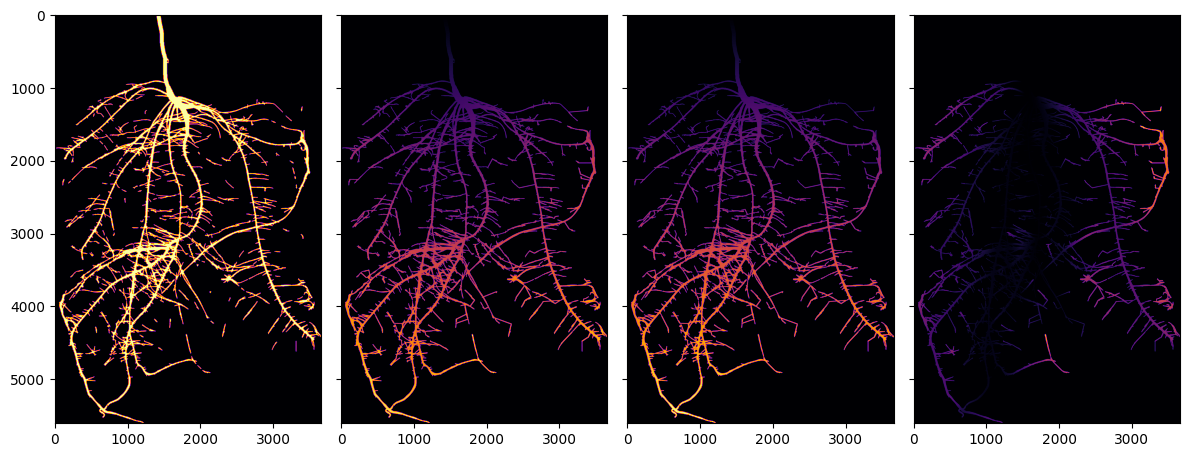

In [79]:
s = np.s_[3500:3600, 500:650]
fig, ax = plt.subplots(1,4, figsize=(12,9), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, gdt, vdt, ddt]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    #ax[i].axvline(im.shape[1]/2, c='r')

#fig.delaxes(ax[-1])
fig.tight_layout()

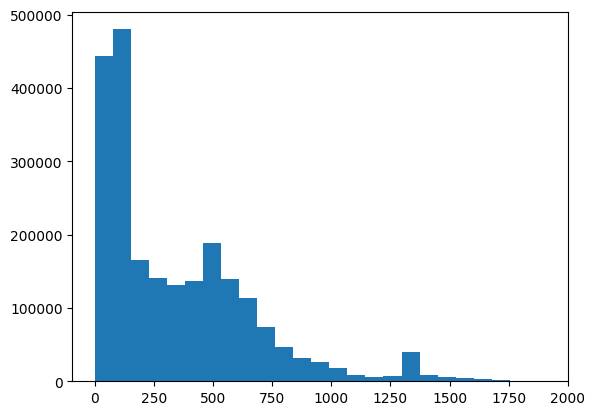

In [80]:
plt.hist(ddt[ddt > 0], bins=25);